# TÜBİTAK 2204-D Lise Öğrencileri İklim Değişikliği Araştırma Projeleri Yarışması 2022
# Kuraklık Tespitine Yapay Zeka ile Bakış: Konya Kapalı Havzası Kuraklık Tahmini
Çalışmamızın kodları bu sayfada mevcuttur.

Bu sayfada;
* 2013 - 2021 yıllarına ait uydu görüntülerinin ve havza sınırı veri setinin incelenmesini,
* 2013 - 2021 yıllarına ait uydu görüntülerinin havza sınırlarına göre kırpılmasını

göreceksiniz.

# Kütüphaneler
earthpy ve rioxarray kütüphaneleri Kaggle'da yüklü olmadığı için ortamımıza yüklememiz gerekmektedir.

In [1]:
!pip install earthpy
!pip install rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 203.3 kB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - done
  Created wheel for rioxarray: filename=rioxarray-0.9.1-py3-none-any.whl size=54609 sha256=4fee59b43fc447fcbdc8cb12aba31cb8002cdad92942996dc459f20591cdf1e4
  Stored in directory: /root/.cache/pip/wheels/07/da/9e/1cc57b2e7a29a206893db83e984a341e2e94378263e0798229
Successfully built rioxarray


In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Uydu Görüntülerinin İçeri Aktarılması

Girdi olarak yıllara göre klasörlere ayrılmış 2013 - 2021 arası Konya Kapalı Havzasına ait Landsat 8-9 Band4 ve Band5 uydu görüntüleri bulunmaktadır.

In [3]:
y2013_path = "../input/konya-kapal-havzas/Bulk Order KKH 2013/Bulk Order KKH 2013/Landsat C2 L2 Band Files"
y2014_path = "../input/konya-kapal-havzas/Bulk Order KKH 2014/Bulk_Order_KKH_2014/Landsat_C2_L2_Band_Files"
y2015_path = "../input/konya-kapal-havzas/Bulk Order KKH 2015/Bulk_Order_KKH_2015/Landsat_C2_L2_Band_Files"
y2016_path = "../input/konya-kapal-havzas/Bulk Order KKH 2016/Bulk Order KKH 2016"

pathlist = [y2013_path, y2014_path, y2015_path, y2016_path]

In [4]:
y2013 = os.listdir(y2013_path)
y2014 = os.listdir(y2014_path)
y2015 = os.listdir(y2015_path)
y2016 = os.listdir(y2016_path)

In [5]:
y2013.sort()
y2014.sort()
y2015.sort()
y2016.sort()
y2013

['148692714.bdapart',
 'LC08_L2SP_176033_20130531_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176033_20130531_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_176033_20130803_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176033_20130803_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_176033_20131022_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176033_20131022_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_176034_20130803_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176034_20130803_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130623_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130623_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130709_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130709_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130725_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130725_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130810_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130810_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130826_20200913_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130911_20200913_02_T1_

Görüldüğü üzere yükleme sırasında uydu görüntüsü dışında olan dosyalar ya da birden fazla yüklenen dosyalar indirilmiştir. Bunları temizlememiz gerekmektedir.

In [6]:
years = [y2013, y2014, y2015, y2016]
for y in years:
    for g in y:
        if g.endswith("B4.TIF") or g.endswith("B5.TIF"):
            continue
        else:
            y.remove(g)

In [7]:
y2013

['LC08_L2SP_176033_20130531_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176033_20130531_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_176033_20130803_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176033_20130803_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_176033_20131022_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176033_20131022_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_176034_20130803_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_176034_20130803_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130623_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130623_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130709_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130709_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130725_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130725_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130810_20200912_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130810_20200912_02_T1_SR_B5.TIF',
 'LC08_L2SP_177033_20130826_20200913_02_T1_SR_B4.TIF',
 'LC08_L2SP_177033_20130911_20200913_02_T1_SR_B4.TIF',
 'LC08_L2S

# Örnek Uydu Görüntülerinin İncelenmesi
Örnek veri seti olarak 2014 yılına ait bir görüntüyü kullanacağız.

In [8]:
band_path = os.path.join(y2014_path, y2014[20])
img_arr = rxr.open_rasterio(band_path, masked = True).squeeze() # nan değerler maskelendi ve 2D halinde
img_arr

<xarray.DataArray (y: 7881, x: 7741)>
[61006821 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 3.315e+05 3.315e+05 ... 5.637e+05 5.637e+05
  * y            (y) float64 4.265e+06 4.265e+06 ... 4.029e+06 4.029e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Örnek görüntü nan değerlerin maskelenmesi ve dizinin 2 boyutlu hale getirilmesi ile açıldı.

In [9]:
img_arr.rio.crs

CRS.from_epsg(32636)

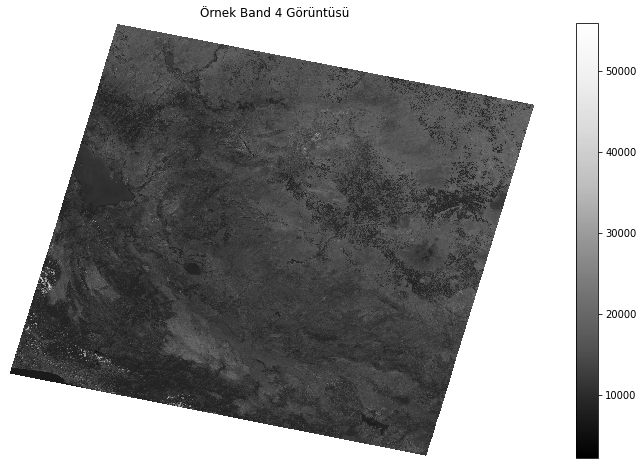

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
img_arr.plot(cmap="Greys_r", ax=ax)
ax.set_title("Örnek Band 4 Görüntüsü")
ax.set_axis_off()
plt.show()

Nan değerleri maskelediğimiz için görüntü daha düzgün çıktı. Aksi halde en dış kısımdaki beyaz alanlar, simsiyah gözükecekti.

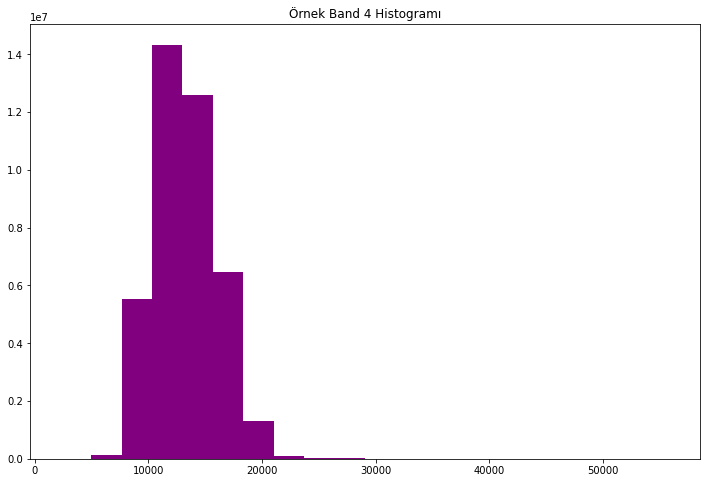

In [11]:
f, ax = plt.subplots(figsize=(12, 8))
img_arr.plot.hist(color="purple", bins=20)
ax.set_title("Örnek Band 4 Histogramı")
plt.show()

Yukarıdaki histogram sayesinde piksellerin yansıma değerlerine göre dağılımını görebiliriz.

In [12]:
print("Minimum: ", np.nanmin(img_arr.data))
print("Maksimum: ", np.nanmax(img_arr.data))

Minimum:  2275.0
Maksimum:  55868.0


# Havza Sınırlarının İçeri Aktarılması ve İncelenmesi
Havza sınırlarıyla ilgili veri seti Ahmet Kargın tarafından yapılmıştır ve izni dahilinde kullanılmaktadır.

In [13]:
havzalar_shp_path = "../input/havza-snrlar-veri-seti-ahmet-kargun/Havza/Havzalar.shp"
havzalar_shp = gpd.read_file(havzalar_shp_path)
havzalar_shp.head()

,OID_,Havza_No,Havza_Rome,Havza_Ad,Shape_Leng,Shape_Area,geometry
0,0,19,XIX,Asi Havzası,6.821481e+05,7.912390e+09,"POLYGON ((1273212.254 4524401.588, 1273597.354..."
1,0,17,XVII,Doğu Akdeniz Havzası,9.398160e+05,2.180703e+10,"POLYGON ((1080637.741 4475037.826, 1080616.520..."
2,0,08,VIII,Batı Akdeniz Havzası,2.086449e+06,2.122387e+10,"POLYGON ((607811.308 4577678.992, 608055.924 4..."
3,0,10,X,Burdur Havzası,5.099270e+05,6.306173e+09,"POLYGON ((677716.858 4626866.095, 678600.177 4..."
4,0,09,IX,Antalya Havzası,1.041579e+06,2.033084e+10,"POLYGON ((772655.246 4639731.800, 772655.246 4..."


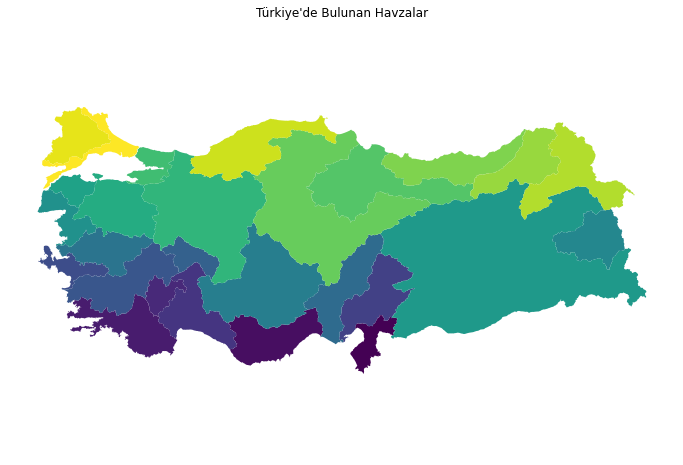

In [14]:
f, ax = plt.subplots(figsize=(12, 8))
havzalar_shp.plot(cmap='viridis', ax=ax)
ax.set(title="Türkiye'de Bulunan Havzalar")
plt.axis('equal')
ax.set_axis_off()
plt.show()

In [15]:
havzalar_shp.crs

<Projected CRS: PROJCS["Europe_Lambert_Conformal_Conic",GEOGCS["GC ...>
Name: Europe_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: European Datum 1950
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

Uydu görüntüsü ile havza sınırı crs sistemleri birbirleri ile uyuşmuyor. Bu yüzden havza sınırlarına bu crs'ye göre yeniden düzenlemeliyiz (reproject). Çünkü kırpma işlemimiz için uydu bantlarımız ile havza sınırlarımız aynı koordinat referans sistemi üzerinde olmalılar.

In [16]:
havzalar_shp = havzalar_shp.to_crs(crs=img_arr.rio.crs)

In [17]:
havzalar_shp.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Konya Kapalı Havzası Sınırlarının Elde Edilmesi
Kullandığımız havza sınırları verisinden Konya Kapalı Havzasını seçeceğiz.

In [18]:
havzalar_shp

,OID_,Havza_No,Havza_Rome,Havza_Ad,Shape_Leng,Shape_Area,geometry
0,0,19,XIX,Asi Havzası,6.821481e+05,7.912390e+09,"POLYGON ((861146.221 4118233.518, 861531.073 4..."
1,0,17,XVII,Doğu Akdeniz Havzası,9.398160e+05,2.180703e+10,"POLYGON ((669562.116 4067451.457, 669539.006 4..."
2,0,08,VIII,Batı Akdeniz Havzası,2.086449e+06,2.122387e+10,"POLYGON ((197064.296 4163881.400, 197313.775 4..."
3,0,10,X,Burdur Havzası,5.099270e+05,6.306173e+09,"POLYGON ((266112.669 4213994.321, 266992.051 4..."
4,0,09,IX,Antalya Havzası,1.041579e+06,2.033084e+10,"POLYGON ((360683.003 4228122.934, 360687.728 4..."
5,0,20,XX,Ceyhan Havzası,1.092761e+06,2.159851e+10,"POLYGON ((861146.221 4118233.518, 860813.120 4..."
6,0,06,VI,Küçük Menderes Havzası,9.359672e+05,7.059738e+09,"POLYGON ((-17292.927 4274497.906, -17183.080 4..."
7,0,07,VII,Büyük Menderes Havzası,1.226392e+06,2.613320e+10,"POLYGON ((219332.542 4312784.313, 219387.998 4..."
8,0,11,XI,Akarçay Havzası,5.535535e+05,7.982578e+09,"POLYGON ((373502.321 4214384.256, 373174.046 4..."
9,0,18,XVIII,Seyhan Havzası,1.071523e+06,2.224157e+10,"POLYGON ((827758.383 4344848.051, 828030.399 4..."


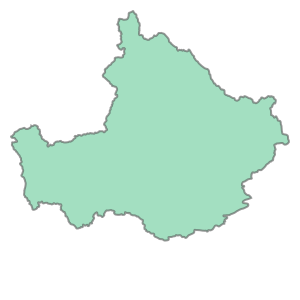

In [19]:
havzalar_shp.iloc[11].geometry

Konya Kapalı Havzası bu şekilde gözükmektedir.

In [20]:
kkh_dict = {"Havza_Ad" : [havzalar_shp["Havza_Ad"][11]], "geometry": [havzalar_shp["geometry"][11]]}
kkh_shp = gpd.GeoDataFrame(kkh_dict, crs= havzalar_shp.crs) # Kırpma işlemi için GeoDataFrame olmalı
kkh_shp

,Havza_Ad,geometry
0,Konya Kapalı Havzası,"POLYGON ((679586.461 4205920.914, 679013.990 4..."


Görüldüğü üzere GeoDataFrame tipinde bir değişkenimiz oldu.

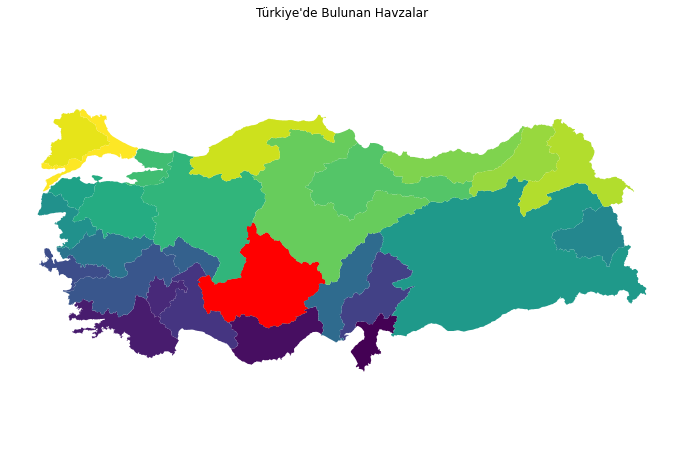

In [21]:
f, ax = plt.subplots(figsize=(12, 8))
havzalar_shp.plot(cmap='viridis', ax=ax)
kkh_shp.plot(color = "red", ax=ax)
ax.set(title="Türkiye'de Bulunan Havzalar")
plt.axis('equal')
ax.set_axis_off()
plt.show()

Sonradan kullanabilmek için elde ettiğimiz veriyi kaydedelim.

In [22]:
kkh_shp.to_file("./Konya_Kapali_Havzasi_Polygon.shp")

# Konya Kapalı Havzası Sınırları Üzerinde Raster Uydu Görüntüsünün Gösterimi
Uydu görüntüsünün havza içerisinde doğru olarak yerleştiğine emin olmak için önemli.

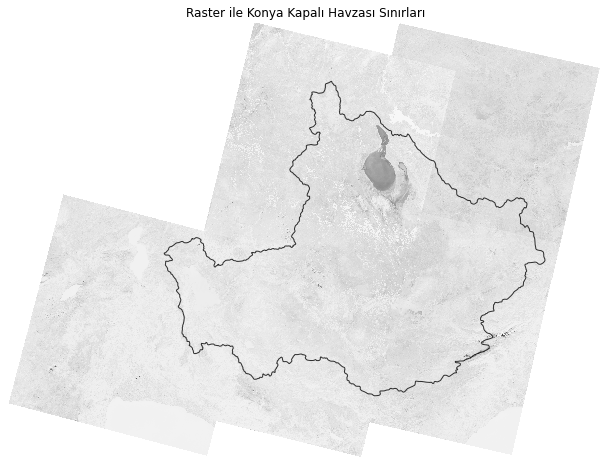

In [23]:
f, ax = plt.subplots(figsize=(12, 8))
for i in range(0, len(y2014)+1, 4):
    if y2014[i].endswith("B4.TIF"):
        band_path2 = os.path.join(y2014_path, y2014[i])
        img_arr2 = rxr.open_rasterio(band_path2, masked=True).squeeze()
        img_arr2.plot.imshow(cmap="Greys", ax=ax, add_colorbar=False)

kkh_shp.plot(color = 'none', edgecolor='black', ax=ax, alpha=.8)
ax.set(title="Raster ile Konya Kapalı Havzası Sınırları")
ax.set_axis_off()
plt.show()

# Uydu Görüntülerinin Havza Sınırlarına Göre Kırpılması
Uydu görüntülerinin hepsi sadece Konya Kapalı Havzasını kapsamamaktadır. Bu yüzden havza dışı alanları kırpmalıyız.

In [24]:
for year in range(2013,2017):
    os.mkdir("./Year_"+ str(year))
    
os.listdir("./")

['Year_2014',
 'Konya_Kapali_Havzasi_Polygon.dbf',
 'Konya_Kapali_Havzasi_Polygon.shx',
 'Konya_Kapali_Havzasi_Polygon.shp',
 '__notebook__.ipynb',
 'Year_2016',
 'Year_2015',
 'Konya_Kapali_Havzasi_Polygon.cpg',
 'Konya_Kapali_Havzasi_Polygon.prj',
 'Year_2013']

In [25]:
def clipping4all(bandlist, path):
    sayac = 0
    for uydu in bandlist:
        sayac+=1
        inpath = os.path.join(path, uydu) # görüntünün adresi
        year = uydu[17:21]
        outpath = os.path.join("./Year_"+ str(year), uydu)
        
        img_pre_arr = rxr.open_rasterio(inpath, masked=True).squeeze() # No data değerler maskelendi ve 2D
        img_clipped = img_pre_arr.rio.clip(kkh_shp.geometry.apply(mapping)) # Kırpılma
        img_clipped.rio.to_raster(outpath) # Yeni görüntüyü kaydetme
        if sayac%5 == 0:
            print("İşlem {} tamamlandı.".format(sayac)) # İşlemleri takip edebilmek için
            time.sleep(2) # Programın dinlenmesi için   
    print("*******************")

Fonksiyona göre uydu görüntüsünün adres yolu raster şeklinde açıldı ve img_pre_arr değişkeni içerisine atandı. Öncesinde tanımladığımız havza sınırı üzerine kırpıldı ve yeni raster goruntu kaydedildi. Bu işlemler bir döngü ile her bir görüntü için tekrar edildi. Döngüden önce sayac değişkeni tanımlandı ve her bir işlemde bu değişkene 1 eklendi. Bunun sonucunda işlemleri takip edebilmek ve sistemi dinlendirmek için sayac değişkeni 5 ve 5'in katı olduğu zaman "İşlem {sayac} tamamlandı." şeklinde bilgilendirme yapılmış ve sistem 2 saniye dinlendirilmiştir. Ayrıca takibi kolaylaştırmak için yıllara göre bilgilendirme yapılmıştır.

In [26]:
for a in range(len(years)):
    clipping4all(years[a], pathlist[a])

İşlem 5 tamamlandı.
İşlem 10 tamamlandı.
İşlem 15 tamamlandı.
İşlem 20 tamamlandı.
İşlem 25 tamamlandı.
İşlem 30 tamamlandı.
*******************
İşlem 5 tamamlandı.
İşlem 10 tamamlandı.
İşlem 15 tamamlandı.
İşlem 20 tamamlandı.
İşlem 25 tamamlandı.
İşlem 30 tamamlandı.
*******************
İşlem 5 tamamlandı.
İşlem 10 tamamlandı.
İşlem 15 tamamlandı.
İşlem 20 tamamlandı.
İşlem 25 tamamlandı.
İşlem 30 tamamlandı.
İşlem 35 tamamlandı.
*******************
İşlem 5 tamamlandı.
İşlem 10 tamamlandı.
İşlem 15 tamamlandı.
İşlem 20 tamamlandı.
İşlem 25 tamamlandı.
İşlem 30 tamamlandı.
*******************


Şimdi de görüntülerde nasıl kırpıldığına bakalım.

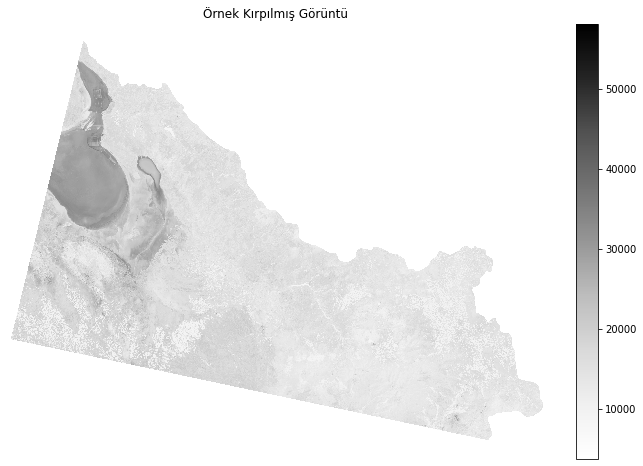

In [27]:
f, ax = plt.subplots(figsize=(12, 8))
example_path = os.path.join("./Year_2014", y2014[0])
example = rxr.open_rasterio(example_path, masked = True).squeeze()
example.plot(ax = ax, cmap = "Greys")
ax.set(title="Örnek Kırpılmış Görüntü")
ax.set_axis_off()
plt.show()